In [1]:
!pip install -U segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 679.1 kB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import tifffile as tiff
from tqdm.auto import tqdm
from glob import glob
import gc
import os
import warnings 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
gc.enable()
warnings.simplefilter('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
import albumentations as A
from sklearn.model_selection import train_test_split
import segmentation_models as sm
from segmentation_models import Unet
from tensorflow.keras import layers


sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [3]:
cfg = {
    'train_df': '../input/hubmap-organ-segmentation/train.csv',
    'train_img': '../input/hubmap-organ-segmentation/train_images/',
    'train_annot': '../input/hubmap-organ-segmentation/train_annotations/',
    'batch size': 4,
    'epochs': 25,
    'img_shape': 512,
    'lr': 1e-03
}

In [4]:
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(mask_rle, shape=(1600,256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [5]:
df = pd.read_csv(cfg['train_df'])
del df['age'], df['img_height'], df['img_width'], df['pixel_size'], df['tissue_thickness'], df['sex'], df['data_source'], df['organ']
df['augmentation'] = None
df.head()

,id,rle,augmentation
0,10044,1459676 77 1462675 82 1465674 87 1468673 92 14...,None
1,10274,715707 2 718705 8 721703 11 724701 18 727692 3...,None
2,10392,1228631 20 1231629 24 1234624 40 1237623 47 12...,None
3,10488,3446519 15 3449517 17 3452514 20 3455510 24 34...,None
4,10610,478925 68 481909 87 484893 105 487863 154 4908...,None


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            351 non-null    int64 
 1   rle           351 non-null    object
 2   augmentation  0 non-null      object
dtypes: int64(1), object(2)
memory usage: 8.4+ KB


In [7]:
class DataSetGen(tf.keras.utils.Sequence):
    def __init__(
        self, df,
        img_dir=cfg['train_img'],
        img_shape=cfg['img_shape'],
        batch_size=cfg['batch size'],
        validation_split=0.2,
        augments= True,
        shuffle=True
    ):
        self.img_dir = img_dir
        self.img_shape = img_shape
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augments = augments
        self.idx = 3
        
        if augments:    
            if self.idx % 2 ==0:
                self.transform = A.Compose([
                    A.augmentations.crops.RandomResizedCrop(height=self.img_shape, width=self.img_shape),
                    A.augmentations.Rotate(limit=90, p=0.5),
                    A.augmentations.HorizontalFlip(p=0.5),
                    A.augmentations.VerticalFlip(p=0.5),
                    A.augmentations.transforms.ColorJitter(p=0.5),
                    A.OneOf([
                        A.OpticalDistortion(p=0.5),
                        A.GridDistortion(p=.5),
                        A.PiecewiseAffine(p=0.5),
                    ], p=0.5),
                    A.OneOf([
                        A.HueSaturationValue(10, 15, 10),
                        A.CLAHE(clip_limit=4),
                        A.RandomBrightnessContrast(),            
                    ], p=0.5)
                ])
                
            else:
                self.transform = A.Compose([
                    A.RandomCrop(width=self.img_shape, height=self.img_shape),
                    A.OneOf([
                        A.HorizontalFlip(p=0.5),
                        A.VerticalFlip(p=0.5)
                    ]),
                    A.RandomBrightnessContrast(p=0.2)
                ])
            
        self.df = df; self.df = self.on_epoch_end()
                
        
    def on_epoch_end(self):
        '''
        Called after the end of every epoch, here it shuffles the dataframe
        '''
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
        return self.df
    
    
    def __len__(self):
        '''
        Denotes the number of batches per epoch
        '''
        return len(self.df) // self.batch_size
    
    
    def __getitem__(self, idx):
        '''
        Generates one batch of data
        '''
        batch = self.df[idx * cfg['batch size'] : (idx+1) * cfg['batch size']]
        X = []; Y = []
        for _, row in batch.iterrows():
            img_id = str(row['id']) + '.tiff'
            img_path = os.path.join(self.img_dir, img_id)
            rle = row['rle']; aug_type = row['augmentation']
            del row; del img_id; gc.collect()
            img, mask = self.__get_data(img_path, rle)
            if self.augments:
                aug = self.transform(image=img, mask=mask)
                img = aug['image'] / 255.0; mask = aug['mask']
            else:
                img = img / 255.0
            X.append(img); Y.append(mask)
        return np.array(X), np.array(Y).astype(np.float32)
    

    def __get_data(self, img_path, rle):
        '''
        Reads image and masks, generates tiles
        '''
        img = np.array(Image.open(img_path))
        mask = rle2mask(rle, (img.shape[0], img.shape[1]))
        img = cv2.resize(img, (self.img_shape, self.img_shape)).astype('uint8')
        mask = cv2.resize(mask, (self.img_shape, self.img_shape)).reshape((self.img_shape, self.img_shape, 1)).astype('int')
        return img, mask

In [8]:
train_df, valid_df = train_test_split(df, test_size=0.2, shuffle=False, random_state=0)
train_ds = DataSetGen(train_df)
valid_ds = DataSetGen(valid_df, augments=False)

In [9]:
# train = DataSetGen(train_df)
# valid = DataSetGen(valid_df)

# train_ds = tf.data.Dataset.from_generator(
#     train,
#     output_types=(tf.float32, tf.int8),
#     output_shapes=((cfg['img_shape'], cfg['img_shape'], 3), (cfg['img_shape'], cfg['img_shape'], 1))
# )

# valid_ds = tf.data.Dataset.from_generator(
#     valid,
#     output_types=(tf.float32, tf.int8),
#     output_shapes=((cfg['img_shape'], cfg['img_shape'], 3), (cfg['img_shape'], cfg['img_shape'], 1))
# )

# at = tf.data.AUTOTUNE
# train_ds = train_ds.prefetch(at)#.batch(cfg['batch size'])
# valid_ds = valid_ds.prefetch(at)#.batch(cfg['batch size'])

In [10]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1e-06):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou


def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true = tf.cast(y_true, tf.float32)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(tf.cast(y_true, tf.float32), y_pred) + 0.5 * dice_loss(tf.cast(y_true, tf.float32), y_pred)

def weighted_loss(y_true, y_pred):
    # Calculate the base loss
    ce = K.sparse_categorical_crossentropy(y_true, y_pred)
    # Apply the weights
    one_weight = 1.0
    zero_weight = 1e-2
    weight_vector = y_true * one_weight + (1. - y_true) * zero_weight
    weight_vector = K.squeeze(weight_vector, axis=-1)
    weighted_ce = weight_vector * ce

    # Return the mean error
    return K.mean(weighted_ce)

def soft_dice_loss(y_true, y_pred, epsilon=1e-6):
    #ref: https://www.jeremyjordan.me/semantic-segmentation/
    y_true = tf.cast(y_true, tf.float32)
    axes = tuple(range(1, len(y_pred.shape)-1)) 
    numerator = 2. * np.sum(y_pred * y_true, axes)
    denominator = np.sum(np.square(y_pred) + np.square(y_true), axes)
    return 1 - np.mean((numerator + epsilon) / (denominator + epsilon))

In [11]:
base = sm.FPN('efficientnetb3', encoder_weights='imagenet', classes=1, activation='sigmoid')
inpt = tf.keras.Input(shape=(cfg['img_shape'], cfg['img_shape'], 3))
out = base(inpt)
model = tf.keras.Model(inputs=inpt, outputs=out)
model.summary()

44122112/44107200 [==============================] - 14s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
model (Functional)           (None, None, None, 1)     13911721  
Total params: 13,911,721
Trainable params: 13,822,121
Non-trainable params: 89,600
_________________________________________________________________


In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=cfg['lr']),#SGD(learning_rate=cfg['lr'], momentum=0.9, nesterov=True)
    loss= sm.losses.bce_jaccard_loss, #tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics= [iou_coef, sm.metrics.f1_score]
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='/kaggle/working/best_model.h5',
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.9,
    patience=2,
    verbose=0,
    mode='min'
)

es = tf.keras.callbacks.EarlyStopping(
    patience=6,
    min_delta=0,
    monitor='val_loss',
    restore_best_weights=True,
    verbose=0,
    mode='min',
    baseline=None
)

history = model.fit(train_ds, 
                    validation_data=valid_ds,
                    use_multiprocessing=True,
                    workers=4,
                    epochs = cfg['epochs'],
                    callbacks=[es,reduce_lr,checkpoint],
                    verbose=1
                   )

Epoch 1/25
70/70 [==============================] - 154s 2s/step - loss: 0.9752 - iou_coef: 0.2591 - f1-score: 0.4419 - val_loss: 1.3376 - val_iou_coef: 0.3242 - val_f1-score: 0.5375
Epoch 2/25
70/70 [==============================] - 140s 2s/step - loss: 0.7403 - iou_coef: 0.3970 - f1-score: 0.6147 - val_loss: 1.6963 - val_iou_coef: 0.2397 - val_f1-score: 0.4332
Epoch 3/25
70/70 [==============================] - 133s 2s/step - loss: 0.6660 - iou_coef: 0.4493 - f1-score: 0.6591 - val_loss: 0.8587 - val_iou_coef: 0.4452 - val_f1-score: 0.5871
Epoch 4/25
70/70 [==============================] - 136s 2s/step - loss: 0.5856 - iou_coef: 0.5009 - f1-score: 0.7085 - val_loss: 0.6723 - val_iou_coef: 0.4576 - val_f1-score: 0.6884
Epoch 5/25
70/70 [==============================] - 139s 2s/step - loss: 0.5330 - iou_coef: 0.5501 - f1-score: 0.7458 - val_loss: 0.6358 - val_iou_coef: 0.4908 - val_f1-score: 0.6997
Epoch 6/25
70/70 [==============================] - 138s 2s/step - loss: 0.5077 - iou

In [13]:
history.history.keys()

dict_keys(['loss', 'iou_coef', 'f1-score', 'val_loss', 'val_iou_coef', 'val_f1-score', 'lr'])

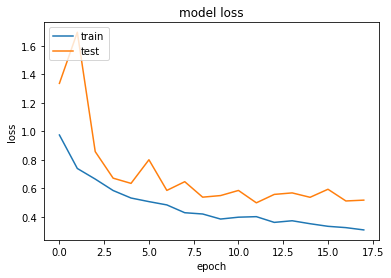

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

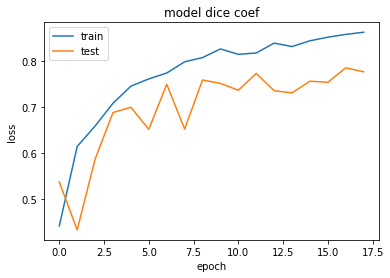

In [15]:
plt.plot(history.history['f1-score'])
plt.plot(history.history['val_f1-score'])
plt.title('model dice coef')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

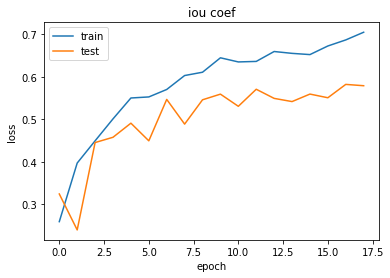

In [16]:
plt.plot(history.history['iou_coef'])
plt.plot(history.history['val_iou_coef'])
plt.title('iou coef')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

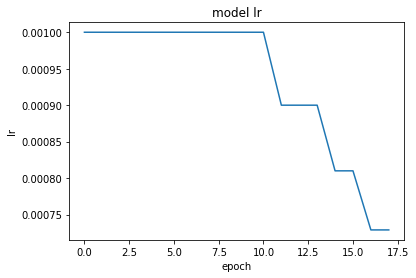

In [17]:
plt.plot(history.history['lr'])
plt.title('model lr')
plt.ylabel('lr')
plt.xlabel('epoch')
plt.show()